# Linear Regression with Gradient Descent

In this notebook, we'll implement linear regression from scratch using PyTorch, predicting monthly rent for Paris apartments based on surface area.

We will:
1. Create a synthetic dataset based on Paris rental prices
2. Implement gradient descent **manually** (computing derivatives by hand)
3. Visualize the optimization process on the loss surface

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## 1. Generate a Synthetic Dataset

We'll create a synthetic dataset representing Paris apartment rentals:
- **Surface**: apartment size in m² (20 to 100 m²)
- **Rent**: monthly rent in euros

Typical Paris rent is around 30-35€/m², so we'll use:
$$\text{rent} = 32 \times \text{surface} + 200 + \text{noise}$$

The intercept (200€) represents fixed costs.

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# True parameters (what we want to recover)
TRUE_W = 32.0  # Price per m² (slope)
TRUE_B = 200.0  # Fixed cost (intercept)

# Generate data: 50 apartments
n_samples = 50
surface = torch.rand(n_samples) * 80 + 20  # Surface: 20-100 m²
noise = torch.randn(n_samples) * 100  # Add some noise
rent = TRUE_W * surface + TRUE_B + noise

print(f"Dataset: {n_samples} Paris apartments")
print(f"Surface range: {surface.min():.1f} - {surface.max():.1f} m²")
print(f"Rent range: {rent.min():.0f} - {rent.max():.0f} €")
print(f"\nTrue parameters: w={TRUE_W}, b={TRUE_B}")

Dataset: 50 Paris apartments
Surface range: 20.5 - 96.7 m²
Rent range: 781 - 3557 €

True parameters: w=32.0, b=200.0


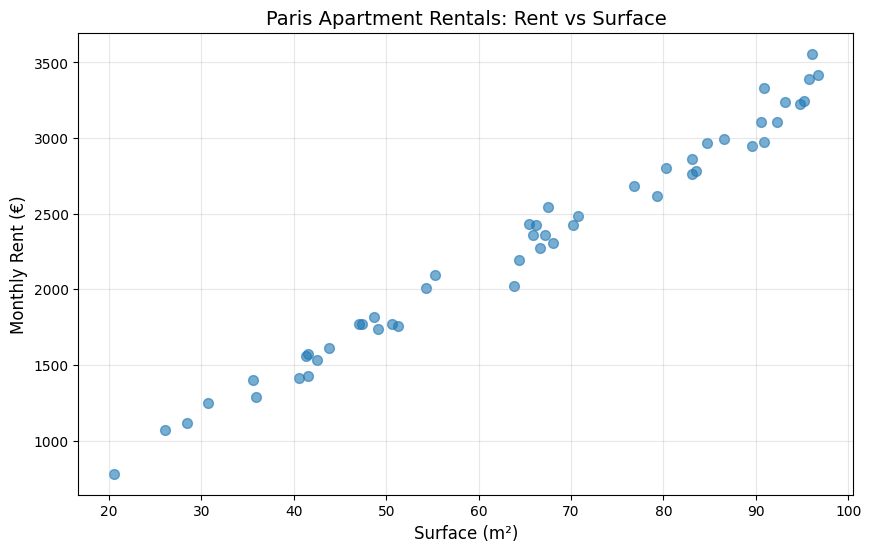

In [3]:
# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.scatter(surface.numpy(), rent.numpy(), alpha=0.6, s=50)
plt.xlabel('Surface (m²)', fontsize=12)
plt.ylabel('Monthly Rent (€)', fontsize=12)
plt.title('Paris Apartment Rentals: Rent vs Surface', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

The goal is now to recover these parameters (32, 200) by training a very simple regression model on this dataset.

## 2. Linear Regression Model

We start with one of the most basic prediction models: a linear regression.

Our model is:
$$\hat{y} = w \cdot x + b$$

where:
- $x$ = surface (input)
- $\hat{y}$ = predicted rent (output)
- $w$ = weight (price per m²)
- $b$ = bias (fixed cost)

Our goal is to find the "best" straight line that fits this dataset, i.e., that is the closest to all the points.

In [4]:
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider

def plot_regression_interactive(w, b):
    """Interactive plot with w and b sliders."""
    
    x_line = torch.linspace(surface.min(), surface.max(), 100)
    y_line = w * x_line + b

    # Create figure
    fig = go.Figure()
    
    # Data points
    fig.add_trace(go.Scatter(
        x=surface.numpy(),
        y=rent.numpy(),
        mode='markers',
        name='Data',
        marker=dict(size=8, opacity=0.6, color='blue'),
    ))
    
    # Regression line
    fig.add_trace(go.Scatter(
        x=x_line.numpy(),
        y=y_line.numpy(),
        mode='lines',
        name=f'Regression Line',
        line=dict(color='red', width=3)
    ))
    
    # True line
    y_true = TRUE_W * x_line + TRUE_B
    fig.add_trace(go.Scatter(
        x=x_line.numpy(),
        y=y_true.numpy(),
        mode='lines',
        name='True Line',
        line=dict(color='green', width=2, dash='dash')
    ))
    
    fig.update_layout(
        title=f'y = {w:.2f}x + {b:.2f}',
        xaxis_title='Surface (m²)',
        yaxis_title='Monthly Rent (€)',
        width=900,
        height=600,
        showlegend=True
    )
    
    fig.show()

# Create interactive widget
interact(
    plot_regression_interactive,
    w=FloatSlider(min=-50, max=50, step=1, value=-3, description='w:'),
    b=FloatSlider(min=0, max=500, step=10, value=10, description='b:')
);

interactive(children=(FloatSlider(value=-3.0, description='w:', max=50.0, min=-50.0, step=1.0), FloatSlider(va…

### Loss Function: Mean Squared Error (MSE)

This is a very classic problem.
To find the best candidate, we will try to minimize the mean squared error on the dataset.

$$L(w, b) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i=1}^{n} (y_i - (w \cdot x_i + b))^2$$

In [5]:
def predict(x, w, b):
    """Make predictions: y_hat = w * x + b"""
    return w * x + b

def mse_loss(y_true, y_pred):
    """Compute Mean Squared Error"""
    return ((y_true - y_pred) ** 2).mean()

## 3. Visualize the Loss Surface

Let's visualize the loss function as a surface over the parameter space $(w, b)$.

In [6]:
# Create grid
w_range = torch.linspace(TRUE_W - 10, TRUE_W + 10, 50)
b_range = torch.linspace(TRUE_B - 100, TRUE_B + 100, 50)
W_grid, B_grid = torch.meshgrid(w_range, b_range, indexing='xy')

# Compute loss on the dataset
Loss_grid = torch.zeros_like(W_grid)
for i in range(len(w_range)):
    for j in range(len(b_range)):
        y_pred = predict(surface, W_grid[j, i].item(), B_grid[j, i].item())
        Loss_grid[j, i] = mse_loss(rent, y_pred)

print(f"\nLoss range: {Loss_grid.min():.2f} to {Loss_grid.max():.2f}")


Loss range: 8716.93 to 641015.56


In [7]:
fig = go.Figure(data=[
    go.Surface(
        x=w_range,
        y=b_range,
        z=Loss_grid,
        colorscale='Viridis',
        opacity=0.8,
        name='Loss Surface'
    )
])

fig.update_layout(
    width=600,
    height=600,
    scene=dict(
        xaxis_title='w (slope)',
        yaxis_title='b (intercept)',
        zaxis_title='Loss (MSE)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    title='Loss Surface (fully centered data: intercept ≈ 0)'
)

fig.show()

## 4. Gradient Descent

To find the optimal values for $w$ and $b$, we will implement **Gradient Descent**.

Gradient: $\nabla L = \left(\frac{\partial L}{\partial w}, \frac{\partial L}{\partial b}\right)$

Update rule:
$$w_{\text{new}} = w_{\text{old}} - \alpha \cdot \frac{\partial L}{\partial w}$$
$$b_{\text{new}} = b_{\text{old}} - \alpha \cdot \frac{\partial L}{\partial b}$$

where $\alpha$ is the learning rate.

But first, we need to compute the gradient of our loss function: $L = \frac{1}{n} \sum_{i=1}^{n} (y_i - (w \cdot x_i + b))^2$

Let's use the chain rule:

### Gradient with respect to $w$:

$$\frac{\partial L}{\partial w} = \frac{\partial}{\partial w} \left[ \frac{1}{n} \sum_{i=1}^{n} (y_i - w \cdot x_i - b)^2 \right]$$

$$= \frac{1}{n} \sum_{i=1}^{n} 2 \cdot (-x_i) \cdot (y_i - w \cdot x_i - b) $$

$$= -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) \cdot x_i$$

### Gradient with respect to $b$:

$$\frac{\partial L}{\partial b} = \frac{\partial}{\partial b} \left[ \frac{1}{n} \sum_{i=1}^{n} (y_i - w \cdot x_i - b)^2 \right]$$

$$= \frac{1}{n} \sum_{i=1}^{n} 2 \cdot (-1) \cdot (y_i - w \cdot x_i - b) $$

$$= -\frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)$$

In [8]:
def compute_gradients(x, y_true, y_pred):
    """
    Compute gradients manually using the formulas derived above.
    
    dL/dw = -2/n * sum((y_true - y_pred) * x)
    dL/db = -2/n * sum(y_true - y_pred)
    """
    n = len(x)
    error = y_true - y_pred
    
    grad_w = -2 * (error * x).sum() / n
    grad_b = -2 * error.sum() / n
    
    return grad_w, grad_b

We now have everything to train our model on the dataset.

In [9]:
# Initialize parameters (random starting point)
w = torch.tensor([25])  # Start around 25
b = torch.tensor([100]) # Start around 100

# Hyperparameters
learning_rate = 0.00001
n_iterations = 200

# Store history for visualization
history = {
    'w': [],
    'b': [],
    'loss': []
}

# Gradient descent loop
for iteration in range(n_iterations):
    # Forward pass - use CENTERED data
    y_pred = predict(surface, w, b)
    loss = mse_loss(rent, y_pred)
    
    # Compute gradients manually - use CENTERED data
    grad_w, grad_b = compute_gradients(surface, rent, y_pred)
    
    # Update parameters
    w = w - learning_rate * grad_w
    b = b - learning_rate * grad_b
    
    # Store history
    history['w'].append(w.item())
    history['b'].append(b.item())
    history['loss'].append(loss.item())
    
    # Print progress
    if (iteration + 1) % 20 == 0:
        print(f"Iter {iteration+1:3d}: Loss={loss.item():8.2f}, w={w.item():.2f}, b={b.item():.2f}")

print(f"\nFinal (centered space): w={w.item():.2f}, b={b.item():.2f}")
print(f"True parameters: w={TRUE_W:.2f}, b={TRUE_B:.2f}")
print(f"Error: Δw={abs(w.item()-TRUE_W):.2f}, Δb={abs(b.item()-TRUE_B):.2f}")

Iter  20: Loss=17335.79, w=32.39, b=100.11
Iter  40: Loss= 9420.29, w=33.42, b=100.12
Iter  60: Loss= 9269.15, w=33.56, b=100.13
Iter  80: Loss= 9266.23, w=33.58, b=100.13
Iter 100: Loss= 9266.12, w=33.58, b=100.13
Iter 120: Loss= 9266.08, w=33.58, b=100.14
Iter 140: Loss= 9266.03, w=33.58, b=100.14
Iter 160: Loss= 9265.99, w=33.58, b=100.14
Iter 180: Loss= 9265.94, w=33.58, b=100.15
Iter 200: Loss= 9265.90, w=33.58, b=100.15

Final (centered space): w=33.58, b=100.15
True parameters: w=32.00, b=200.00
Error: Δw=1.58, Δb=99.85


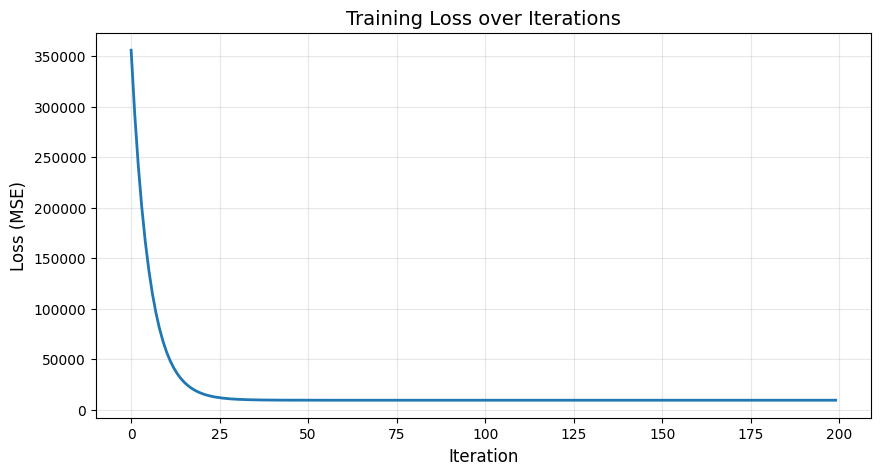

In [10]:
# Plot loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss over Iterations', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [11]:
plot_regression_interactive(w.item(), b.item())

In [12]:
fig = go.Figure(data=[
    go.Surface(
        x=w_range,
        y=b_range,
        z=Loss_grid,
        colorscale='Viridis',
        opacity=0.8,
        name='Loss Surface'
    )
])

# Add history
fig.add_trace(go.Scatter3d(
    x=history['w'],
    y=history['b'],
    z=history['loss'],
    mode='markers',
    marker=dict(size=8, color='red', symbol='circle'),
    name='Start'
))


fig.update_layout(
    width=900,
    height=700,
    scene=dict(
        xaxis_title='w (slope)',
        yaxis_title='b (intercept)',
        zaxis_title='Loss (MSE)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    title='Loss Surface with Gradient Descent Trajectory'
)

fig.show()

## 5. Standardize the Dataset to Balance Gradients

The issue is that $w$ and $b$ operate on very different scales, causing unbalanced gradient magnitudes.

**Why this happens:**
- The gradient for $w$ includes multiplication by $x$ (surface values: 20-100)
- The gradient for $b$ doesn't include $x$
- This creates an elongated "elliptical bowl" in the loss surface
- Different parameters need very different learning rates to converge efficiently

**Solution: Standardize the dataset!**

Standardization transforms both features and targets to have mean=0 and std=1:
$$x_{\text{std}} = \frac{x - \mu_x}{\sigma_x}$$

Benefits:
- Both gradients have similar magnitudes
- Can use a single, larger learning rate
- Faster convergence
- Gradient descent follows a more direct path to the minimum
- The loss surface becomes more "circular" (better conditioned)

In [13]:
# Pre-process: Standardize the dataset
surface_std = (surface - surface.mean()) / surface.std()
rent_std = (rent - rent.mean()) / rent.std()

In [14]:
# Create grid in standardized space
w_range = torch.linspace(-0.5, 2, 50)  # Centered around 1 (correlation)
b_range = torch.linspace(-1, 1, 50)    # Centered around 0
W_grid, B_grid = torch.meshgrid(w_range, b_range, indexing='xy')

# Compute loss on the standardized dataset
Loss_grid = np.zeros_like(W_grid)
for i in range(len(w_range)):
    for j in range(len(b_range)):
        y_pred = predict(surface_std, W_grid[j, i].item(), B_grid[j, i].item())
        Loss_grid[j, i] = mse_loss(rent_std, y_pred)

print(f"\nLoss range: {Loss_grid.min():.2f} to {Loss_grid.max():.2f}")


Loss range: 0.02 to 3.20


In [15]:
fig = go.Figure(data=[
    go.Surface(
        x=w_range,
        y=b_range,
        z=Loss_grid,
        colorscale='Viridis',
        opacity=0.8,
        name='Loss Surface'
    )
])

fig.update_layout(
    width=600,
    height=600,
    scene=dict(
        xaxis_title='w (slope)',
        yaxis_title='b (intercept)',
        zaxis_title='Loss (MSE)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    title='Loss Surface (fully centered data: intercept ≈ 0)'
)

fig.show()

Now let's train again on the standardized dataset.

In [16]:
w = torch.tensor([0.5])  # at 0.5 for standardized
b = torch.tensor([0.5])

learning_rate = 0.1  # Can use much larger now!
n_iterations = 200

history = {'w': [], 'b': [], 'loss': []}

for iteration in range(n_iterations):
    y_pred = predict(surface_std, w, b)
    loss = mse_loss(rent_std, y_pred)
    
    grad_w, grad_b = compute_gradients(surface_std, rent_std, y_pred)
    
    w = w - learning_rate * grad_w
    b = b - learning_rate * grad_b

    
    history['w'].append(w.item())
    history['b'].append(b.item())
    history['loss'].append(loss.item())
    
    if (iteration) % 20 == 0:
        print(f"Iter {iteration:3d}: Loss={loss.item():8.6f}, w={w.item():.4f}, b={b.item():.4f}")


w_original = (w * rent.std() / surface.std())
b_original = (b * rent.std() + rent.mean() - w_original * surface.mean())
print(f"Final (original):     w={w_original.item():.2f}, b={b_original.item():.2f}")
print(f"True parameters:      w={TRUE_W:.2f}, b={TRUE_B:.2f}")

Iter   0: Loss=0.503260, w=0.5963, b=0.4000
Iter  20: Loss=0.016522, w=0.9865, b=0.0046
Iter  40: Loss=0.016450, w=0.9915, b=0.0001
Iter  60: Loss=0.016450, w=0.9916, b=0.0000
Iter  80: Loss=0.016450, w=0.9916, b=-0.0000
Iter 100: Loss=0.016450, w=0.9916, b=-0.0000
Iter 120: Loss=0.016450, w=0.9916, b=-0.0000
Iter 140: Loss=0.016450, w=0.9916, b=-0.0000
Iter 160: Loss=0.016450, w=0.9916, b=-0.0000
Iter 180: Loss=0.016450, w=0.9916, b=-0.0000
Final (original):     w=32.56, b=173.60
True parameters:      w=32.00, b=200.00


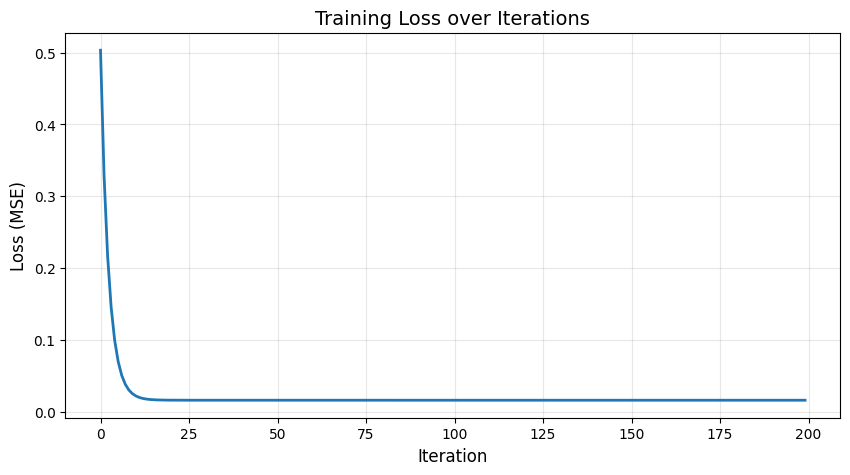

In [17]:
# Plot loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss over Iterations', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
plot_regression_interactive(w_original.item(), b_original.item())

In [19]:
fig = go.Figure(data=[
    go.Surface(
        x=w_range,
        y=b_range,
        z=Loss_grid,
        colorscale='Viridis',
        opacity=0.8,
        name='Loss Surface'
    )
])

# Add history
fig.add_trace(go.Scatter3d(
    x=history['w'],
    y=history['b'],
    z=history['loss'],
    mode='markers',
    marker=dict(size=8, color='red', symbol='circle'),
    name='Start'
))


fig.update_layout(
    width=900,
    height=700,
    scene=dict(
        xaxis_title='w (slope)',
        yaxis_title='b (intercept)',
        zaxis_title='Loss (MSE)',
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
    ),
    title='Loss Surface with Gradient Descent Trajectory'
)

fig.show()

In [20]:
# Add a 2D contour plot to see the true gradient direction
fig2 = go.Figure()

fig2.add_trace(go.Contour(
    x=w_range,
    y=b_range,
    z=Loss_grid,
    colorscale='Viridis',
    contours=dict(showlabels=True),
    name='Loss Contours'
))

# Add trajectory in 2D
fig2.add_trace(go.Scatter(
    x=history['w'],
    y=history['b'],
    mode='lines+markers',
    marker=dict(size=4, color='red'),
    line=dict(color='red', width=2),
    name='GD Path'
))

# Add start/end
fig2.add_trace(go.Scatter(
    x=[history['w'][0]], y=[history['b'][0]],
    mode='markers',
    marker=dict(size=10, color='Yellow', symbol='x'),
    name='Start'
))

fig2.add_trace(go.Scatter(
    x=[history['w'][-1]], y=[history['b'][-1]],
    mode='markers',
    marker=dict(size=12, color='yellow', symbol='x'),
    name='End'
))

fig2.update_layout(
    title='2D Contour: Gradient Descent Path',
    xaxis_title='w',
    yaxis_title='b',
    width=800,
    height=600
)

fig2.show()

## 6. Autodiff Magic: Let PyTorch Compute Gradients

So far, we've manually computed gradients using calculus. Now let's see how PyTorch's **autodiff** system can do this automatically!

When you set `requires_grad=True` on a tensor, PyTorch tracks all operations on it and builds a computational graph. You can then call `.backward()` to automatically compute gradients.

### Comparison: Manual vs Autodiff

**Manual approach** (what we did before):
1. Derive gradients by hand using calculus
2. Implement `compute_gradients()` function
3. Update parameters manually

**Autodiff approach** (PyTorch magic):
1. Mark parameters with `requires_grad=True`
2. Compute loss
3. Call `loss.backward()` → gradients computed automatically!
4. Access gradients via `.grad` attribute

In [21]:
# Test: compute gradients both ways at a random point
w_test = torch.tensor([0.7], requires_grad=True)
b_test = torch.tensor([0.3], requires_grad=True)

# Forward pass
y_pred = predict(surface_std, w_test, b_test)
loss = mse_loss(rent_std, y_pred)

# Autograd gradients
loss.backward()
grad_w_auto = w_test.grad.item()
grad_b_auto = b_test.grad.item()

# Manual gradients
grad_w_manual, grad_b_manual = compute_gradients(surface_std, rent_std, y_pred.detach())
grad_w_manual = grad_w_manual.item()
grad_b_manual = grad_b_manual.item()

print("Gradient Comparison at w=0.7, b=0.3:")
print("=" * 50)
print(f"∂L/∂w:  Autograd={grad_w_auto:.6f}  |  Manual={grad_w_manual:.6f}")
print(f"∂L/∂b:  Autograd={grad_b_auto:.6f}  |  Manual={grad_b_manual:.6f}")
print("=" * 50)
print(f"Difference: Δw={abs(grad_w_auto - grad_w_manual):.10f}, Δb={abs(grad_b_auto - grad_b_manual):.10f}")

Gradient Comparison at w=0.7, b=0.3:
∂L/∂w:  Autograd=-0.571480  |  Manual=-0.571480
∂L/∂b:  Autograd=0.600001  |  Manual=0.600001
Difference: Δw=0.0000000596, Δb=0.0000000000


We can now retry our training loop using PyTorch autodiff.

In [22]:
# Initialize parameters as tensors with gradient tracking
w_auto = torch.tensor([0.5], requires_grad=True) # Track gradients for w
b_auto = torch.tensor([0.5], requires_grad=True) # Track gradients for b

print(f"Initial parameters: w={w_auto.item():.2f}, b={b_auto.item():.2f}")
print(f"w.requires_grad = {w_auto.requires_grad}")
print(f"b.requires_grad = {b_auto.requires_grad}")

learning_rate = 0.1
n_iterations = 200

history_auto = {'w': [], 'b': [], 'loss': []}

for iteration in range(n_iterations):
    # Forward pass
    y_pred = predict(surface_std, w_auto, b_auto)
    loss = mse_loss(rent_std, y_pred)
    
    # Backward pass - AUTOGRAD MAGIC!
    loss.backward()  # Computes ∂L/∂w and ∂L/∂b automatically
    
    # Manual parameter update (no autograd for this part)
    with torch.no_grad():  # Temporarily disable gradient tracking
        w_auto -= learning_rate * w_auto.grad # Update w
        b_auto -= learning_rate * b_auto.grad # Update b
        
    # IMPORTANT: Zero gradients after each step
    w_auto.grad.zero_()
    b_auto.grad.zero_()
    
    # Store history
    history_auto['w'].append(w_auto.item())
    history_auto['b'].append(b_auto.item())
    history_auto['loss'].append(loss.item())
    
    if iteration % 20 == 0:
        print(f"Iter {iteration:3d}: Loss={loss.item():8.6f}, w={w_auto.item():.4f}, b={b_auto.item():.4f}")

# Transform back to original scale
w_auto_original = w_auto * rent.std() / surface.std()
b_auto_original = b_auto * rent.std() + rent.mean() - w_auto_original * surface.mean()

print(f"\nFinal (autograd):     w={w_auto_original.item():.2f}, b={b_auto_original.item():.2f}")
print(f"Final (manual):       w={w_original.item():.2f}, b={b_original.item():.2f}")
print(f"True parameters:      w={TRUE_W:.2f}, b={TRUE_B:.2f}")


Initial parameters: w=0.50, b=0.50
w.requires_grad = True
b.requires_grad = True
Iter   0: Loss=0.503260, w=0.5963, b=0.4000
Iter  20: Loss=0.016522, w=0.9865, b=0.0046
Iter  40: Loss=0.016450, w=0.9915, b=0.0001
Iter  60: Loss=0.016450, w=0.9916, b=0.0000
Iter  80: Loss=0.016450, w=0.9916, b=-0.0000
Iter 100: Loss=0.016450, w=0.9916, b=-0.0000
Iter 120: Loss=0.016450, w=0.9916, b=-0.0000
Iter 140: Loss=0.016450, w=0.9916, b=-0.0000
Iter 160: Loss=0.016450, w=0.9916, b=-0.0000
Iter 180: Loss=0.016450, w=0.9916, b=-0.0000

Final (autograd):     w=32.56, b=173.60
Final (manual):       w=32.56, b=173.60
True parameters:      w=32.00, b=200.00


## 7. With a Neural Network.

Actually, a linear regression is already a very simple instance of a neural network with only one Linear layer.
We can use PyTorch neural nets library and a classic training loop to achieve the same result (again).

In [23]:
model = torch.nn.Linear(1, 1)

model.weight.data = torch.tensor([[0.5]]) # Shape (1, 1)
model.bias.data = torch.tensor([[0.5]]) # Shape (1, 1)

loss_fn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

X_train = surface_std.unsqueeze(1) # Shape: (50, 1)
y_train = rent_std.unsqueeze(1) # Shape: (50, 1)

model.train()

for iteration in range(200):
    # Forward pass
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iteration % 20 == 0:
        print(f"Iter {iteration:3d}: Loss={loss.item():.6f}, w={model.weight.item():.4f}, b={model.bias.item():.4f}")

# After training
print("\nFinal model parameters:")
print(f"Weight (w): {model.weight.item():.4f}")
print(f"Bias (b):   {model.bias.item():.4f}")

# Transform back to original scale
w_nn = model.weight * rent.std() / surface.std()
b_nn = model.bias * rent.std() + rent.mean() - w_nn * surface.mean()

print(f"\nOriginal scale: w={w_nn.item():.2f}, b={b_nn.item():.2f}")
print(f"True parameters: w={TRUE_W:.2f}, b={TRUE_B:.2f}")

Iter   0: Loss=25.163000, w=0.9817, b=-0.0000
Iter  20: Loss=0.822506, w=0.9916, b=-0.0000
Iter  40: Loss=0.822506, w=0.9916, b=-0.0000
Iter  60: Loss=0.822506, w=0.9916, b=-0.0000
Iter  80: Loss=0.822506, w=0.9916, b=-0.0000
Iter 100: Loss=0.822506, w=0.9916, b=-0.0000
Iter 120: Loss=0.822506, w=0.9916, b=-0.0000
Iter 140: Loss=0.822506, w=0.9916, b=-0.0000
Iter 160: Loss=0.822506, w=0.9916, b=-0.0000
Iter 180: Loss=0.822506, w=0.9916, b=-0.0000

Final model parameters:
Weight (w): 0.9916
Bias (b):   -0.0000

Original scale: w=32.56, b=173.60
True parameters: w=32.00, b=200.00


## 8. Make Predictions

Let's use our learned model to predict rent for different apartment sizes.

In [24]:
# Test on new apartments
test_surfaces = torch.tensor([30.0, 50.0, 70.0, 90.0])
predicted_rents = predict(test_surfaces, w_original, b_original)


print(predicted_rents)

print("Rent Predictions for Paris Apartments:")
print("=" * 40)
for surf, rent_pred in zip(test_surfaces, predicted_rents):
    print(rent_pred)
    print(f"Surface: {surf.item():4.0f} m²  →  Rent: {rent_pred:6.0f} €/month")
print("=" * 40)
print(f"\nModel: rent = {w_original.item():.1f} × surface + {b_original.item():.0f}")

tensor([1150.5409, 1801.8350, 2453.1289, 3104.4229])
Rent Predictions for Paris Apartments:
tensor(1150.5409)
Surface:   30 m²  →  Rent:   1151 €/month
tensor(1801.8350)
Surface:   50 m²  →  Rent:   1802 €/month
tensor(2453.1289)
Surface:   70 m²  →  Rent:   2453 €/month
tensor(3104.4229)
Surface:   90 m²  →  Rent:   3104 €/month

Model: rent = 32.6 × surface + 174


## Remark

This problem can be solved in 3 lines of code!

In [25]:
X = torch.stack([surface, torch.ones_like(surface)], dim=1)  # Shape: (50, 2)
y = rent.unsqueeze(1)
solution = torch.linalg.lstsq(X, y)
solution.solution

tensor([[ 32.5647],
        [173.5997]])